In [1]:
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import words
from scipy.sparse import csr_matrix

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
from textblob import TextBlob

from gensim.models import Word2Vec
from collections import Counter

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from gensim.models import Word2Vec
import scipy.sparse as sp
import gensim
from gensim import corpora


[nltk_data] Downloading package omw-1.4 to C:\Users\RIA
[nltk_data]     GOVILA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Load JSON data into a DataFrame
df = pd.read_json("Magazine_Subscriptions.json", lines=True)

print(df)

       overall vote  verified   reviewTime      reviewerID        asin  \
0            5    9     False   11 8, 2001   AH2IFH762VY5U  B00005N7P0   
1            5    9     False  10 31, 2001   AOSFI0JEYU4XM  B00005N7P0   
2            3   14     False  03 24, 2007  A3JPFWKS83R49V  B00005N7OJ   
3            5   13     False  11 10, 2006  A19FKU6JZQ2ECJ  B00005N7OJ   
4            5  NaN      True  07 14, 2014  A25MDGOMZ2GALN  B00005N7P0   
...        ...  ...       ...          ...             ...         ...   
89684        5  NaN      True  08 16, 2016   AB5HCI50SF1TK  B01HI8V1C2   
89685        1  NaN      True  08 10, 2016  A2X11NZMPI7M0T  B01HI8V1C2   
89686        5  NaN      True  07 31, 2016  A3EGFFBRQVO7L7  B01HI8V1C2   
89687        5  NaN      True   10 5, 2017  A3H23AVKFN62ZT  B01HIZSSQM   
89688        5  NaN      True  04 28, 2017  A1N6M7HRWMDE3D  B01HIZSSQM   

             reviewerName                                         reviewText  \
0            ted sedlmayr  for 

In [3]:
#dropping irrelevant columns and keeping only verified =True rows
df = df.drop(['vote', 'reviewTime', 'reviewerName', 'asin', 'unixReviewTime', 'style', 'image'], axis=1)

#Keeping only verified instances in the data
df = df[df['verified'] != False]
#print(df)


In [6]:
# Randomly sample 1000 reviews of each 'overall' category
df1 = df.groupby('overall').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

# Check for NaN values
#print(df1.isna().sum())
df1.to_csv('sampled_data.csv')

# Remove NaN values
df1.dropna(inplace=True)

# Verify the size of the sampled DataFrame
print(df1.shape)

print(df1['overall'].value_counts())


(4999, 5)
1    1000
2    1000
3    1000
4    1000
5     999
Name: overall, dtype: int64


In [7]:
#Data Cleaning
# checking the presence of emoticons in the text - none 
''''''
# Define a regular expression pattern to match emojis
emoji_pattern = re.compile(r"[^\w\s,]")

# Search for emojis in the text column
emojis = df1['reviewText'].str.contains(emoji_pattern)

# Filter the DataFrame to include rows with emojis
emojis_df = df1[emojis]

## Print the rows with emojis
#print(emojis_df)

# checking text in brackets - if there are any and remove if irrelevant

# Regular expression pattern to match text within brackets
pattern = r"\[([^\]]+)\]"

# Initialize a dictionary to store the frequencies
frequency = {}

# Find all matches using the pattern and update the frequencies
# Iterate over each row in the 'text' column
for row in df1['reviewText']:
    # Find all matches using the pattern and update the frequencies
    matches = re.findall(pattern, row)
    for match in matches:
        frequency[match] = frequency.get(match, 0) + 1

## Print the frequencies
# for item, count in frequency.items():
#     print(f"{item}: {count}")
    
#checking number of numbers in the text string and replacing with text equivalent if required
#Define a regular expression pattern to match numbers

number_pattern = r'\d+'

# Iterate over each text entry and count the occurrences of numbers
frequency = {}
for text in df1['reviewText']:
    matches = re.findall(number_pattern, text)
    for match in matches:
        frequency[match] = frequency.get(match, 0) + 1

# # Print the frequency of numbers
# for number, count in frequency.items():
#     print(f"Number: {number}, Frequency: {count}")

import inflect

# Create an instance of the inflect engine
p = inflect.engine()

# Define a function to replace numbers with their text equivalent
def replace_numbers(text):
    number_pattern = r'\d+'
    numbers = re.findall(number_pattern, text)
    for number in numbers:
        text = text.replace(number, p.number_to_words(number))
    return text

#Applying the function to the 'reviewText' column
df1['reviewText'] = df1['reviewText'].apply(replace_numbers)

# Remove punctuation from the 'reviewText' column
df1['reviewText'] = df1['reviewText'].astype(str)
df1['reviewText'] = df1['reviewText'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

df1['reviewText'].fillna('', inplace=True)

# Remove numbers from the 'reviewText' column
df1['reviewText'] = df1['reviewText'].str.replace('\d+', '', regex=True)

# Remove unnecessary spaces and punctuation from the 'reviewText' column
df1['reviewText'] = df1['reviewText'].str.replace('\s+', ' ', regex=True)  # Remove extra spaces
df1['reviewText'] = df1['reviewText'].str.replace('[^\w\s]', '', regex=True)  # Remove punctuation



In [8]:
# Define a function to extract URLs using regex
def extract_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')
    return url_pattern.findall(text)

# Apply the function to the 'reviewText' column in df1
df1['urls'] = df1['reviewText'].apply(extract_urls)

# Flatten the list of URLs and display them
url_list = [url for sublist in df1['urls'] for url in sublist]
print(url_list)


#removing all urls
def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')
    return url_pattern.sub('', text)

# Apply the function to the 'reviewText' column in df1
df1['reviewText'] = df1['reviewText'].apply(remove_urls)


[]


In [7]:
#print(df1['reviewText'])

In [9]:
text = ' '.join(df1['reviewText'])
#print(text)

['TV', 'TV', 'TV', 'US', 'RECEIVED', 'C', 'U', 'CHEAT', 'CUSTOMERS', 'NEVER', 'RECEIVED', 'ONE', 'MAGAZINE', 'GRANDDAUGHTER', 'DISAPPOINTED', 'U', 'PROBABLY', 'SCREW', 'EVERYONE', 'LIKE', 'LARRY', 'HUBBARD', 'LWHUBRDAOLCOM', 'IPAD', 'WIRED', 'TV', 'PM', 'USA', 'ADVERTISING', 'HAVENT', 'RECEIVED', 'YET', 'GET', 'ONE', 'LET', 'KNOW', 'BAD', 'COULD', 'GET', 'SHIPPED', 'CANADA', 'SURE', 'ENJOY', 'READING', 'WATCH', 'EVER', 'GETS', 'WHATS', 'DEAL', 'WAY', 'KNEW', 'SHIPPED', 'RIGHT', 'AWAY', 'HEY', 'LONG', 'ENOUGH', 'SINCE', 'ORDERED', 'SLOW', 'RECEIVED', 'ISSUE', 'YET', 'BETTER', 'REALLY', 'SOOOOON', 'TV', 'PS', 'OK', 'OK', 'NG', 'EXCEPT', 'GETTING', 'PRODUCT', 'PAID', 'JULY', 'LONG', 'TAB', 'SUCKS', 'PCGAMER', 'PC', 'DVD', 'DVD', 'WHOA', 'PCGAMER', 'PC', 'PC', 'PCGAMER', 'DONT', 'ORDER', 'GREAT', 'REKNEWED', 'LOT', 'SUBSCRIBE', 'AMAZON', 'NEVER', 'GOT', 'ISSUE', 'TOTALLY', 'WASTE', 'MONEY', 'RATHER', 'BUY', 'CUP', 'COFFEE', 'KNOW', 'LOVE', 'GF', 'GF', 'ZERO', 'NOTHING', 'WOW', 'IEEE', 'IEE

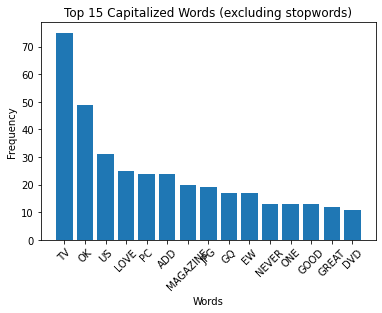

Word            Frequency  Proportion (%) 
TV              75         4.58%
OK              49         2.99%
US              31         1.89%
LOVE            25         1.53%
PC              24         1.47%
ADD             24         1.47%
MAGAZINE        20         1.22%
JPG             19         1.16%
GQ              17         1.04%
EW              17         1.04%
NEVER           13         0.79%
ONE             13         0.79%
GOOD            13         0.79%
GREAT           12         0.73%
DVD             11         0.67%
RECEIVED        10         0.61%
USA             10         0.61%
ESPN            10         0.61%
RD              10         0.61%
TIME            9          0.55%
HD              9          0.55%
DIY             9          0.55%
ISSUE           8          0.49%
DONT            8          0.49%
AMAZON          8          0.49%
FIRST           8          0.49%
READ            8          0.49%
REALLY          7          0.43%
STILL           7          0.43%


In [30]:
# Find capitalized words using regex pattern
capitalized_words = re.findall(r'\b[A-Z]+\b', text)

# Tokenize the capitalized words
tokens = word_tokenize(' '.join(capitalized_words))


# Remove stopwords from the tokens
stopword_list = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.lower() not in stopword_list]

print(filtered_tokens)






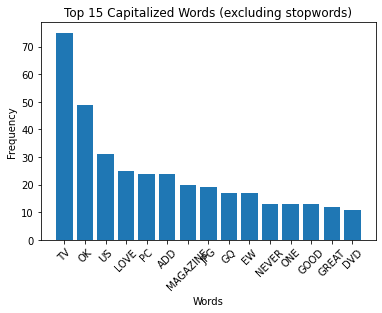

Word            Frequency  Proportion (%) 
TV              75         4.58%
OK              49         2.99%
US              31         1.89%
LOVE            25         1.53%
PC              24         1.47%
ADD             24         1.47%
MAGAZINE        20         1.22%
JPG             19         1.16%
GQ              17         1.04%
EW              17         1.04%
NEVER           13         0.79%
ONE             13         0.79%
GOOD            13         0.79%
GREAT           12         0.73%
DVD             11         0.67%
RECEIVED        10         0.61%
USA             10         0.61%
ESPN            10         0.61%
RD              10         0.61%
TIME            9          0.55%
HD              9          0.55%
DIY             9          0.55%
ISSUE           8          0.49%
DONT            8          0.49%
AMAZON          8          0.49%
FIRST           8          0.49%
READ            8          0.49%
REALLY          7          0.43%
STILL           7          0.43%


In [33]:

# Aim : Plot top 15 words, Check top 50 words, screen and check 3 word-ngram for identified sentiments


# Count the frequency of each word
word_counts = Counter(filtered_tokens)

# Get the top 15 words and their counts
top_words = word_counts.most_common(15)

# Extract the words and counts for plotting
words, counts = zip(*top_words)

# Plot the top 15 words
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Capitalized Words (excluding stopwords)')
plt.xticks(rotation=45)
plt.show()

# Calculate the total frequency of all capitalized words
total_frequency = sum(word_counts.values())

# Get the top 50 words and their counts
top_words = word_counts.most_common(50)

# Print the table header
print(f"{'Word':<15} {'Frequency':<10} {'Proportion (%)':<15}")
print("="*40)

# Print the top capitalized words, their frequencies, and proportions
for word, count in top_words:
    proportion = (count / total_frequency) * 100
    print(f"{word:<15} {count:<10} {proportion:.2f}%")

# Check 3 word ngrams for the following words:

top_words = ['NEVER', 'GOOD', 'GREAT', 'LOVE']

# Generate and print the three-word ngrams for each word
for word in top_words:
    # Generate three-word ngrams
    three_word_ngrams = list(ngrams(filtered_tokens, 3))
    three_word_ngrams = [' '.join(ngram) for ngram in three_word_ngrams if word in ngram]
    
    print(f"Three-word ngrams for '{word}':")
    for ngram in three_word_ngrams:
        print(ngram)
    print()
    
    
    

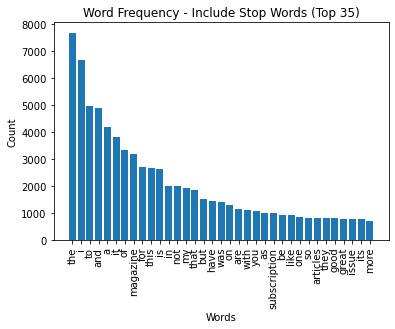

In [34]:
#Check top 35 words in full text

word_counts = {}
words = text.split()

for word in words:
    #lower case text
    word = word.lower()
    word_counts[word] = word_counts.get(word, 0) + 1

sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

top_words = [word for word, count in sorted_counts[:35]]
top_counts = [count for word, count in sorted_counts[:35]]

plt.bar(top_words, top_counts)
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Word Frequency - Include Stop Words (Top 35)")
plt.xticks(rotation=90)
plt.show()

# we notice a lot of stop words and word 'magazine' and 'subscription' being repeated we will get rid and repeat


In [35]:


# Initialize the stemmer
stemmer = PorterStemmer()

# Remove stop words and variations of irrelevant words from the text string
words = text.split()
filtered_words = [word.lower() for word in words if word.lower() not in stop_words 
                  and not word.lower().startswith(('magazin', 'issue'))
                  and stemmer.stem(word.lower()) not in ["subscript", "amazon", "articl","mag","one"]]
                 #and not word.lower().startswith(('magazin'))
                  #and stemmer.stem(word.lower()) not in ["amazon","mag","one"]]

# Count the occurrence of each word
y = pd.Series(filtered_words).apply(word_tokenize)

# Create a new DataFrame with unnested tokens
y = y.explode().reset_index(drop=True)

# Print the first 30 rows of the new DataFrame
#print(y.head(30))
#y.info()


[nltk_data] Downloading package stopwords to C:\Users\RIA
[nltk_data]     GOVILA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


like           908
good           798
great          781
read           634
would          630
get            618
love           486
two            477
received       454
first          450
time           439
much           437
dont           431
many           415
ads            411
year           393
really         379
years          371
recipes        323
new            317
reading        315
still          314
im             303
got            301
even           288
price          285
never          273
content        271
ordered        268
every          262
month          258
find           255
well           254
always         253
information    246
dtype: int64


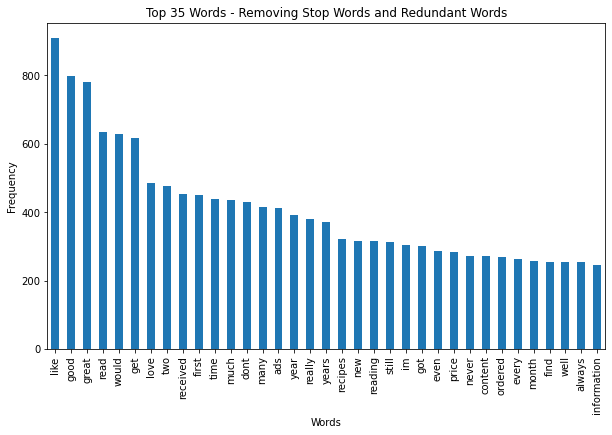

In [49]:
# Sort the word counts in descending order
y_freq = y.value_counts().reset_index()
y_freq.columns = ['word_token', 'n']

# Sort the word frequencies in descending order
word_counts_tok = y.value_counts().head(35)
print(word_counts_tok)

# Create a bar chart of the top 35 words
plt.figure(figsize=(10, 6))
word_counts_tok.plot(kind='bar')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 35 Words - Removing Stop Words and Redundant Words')
plot_lemmatized = plt.gcf()
plt.show()

In [42]:
# # exploring higher order n-grams
# from nltk import ngrams


# Define the words
words = ['like', 'good', 'great', 'get', 'read', 'would', 'two', 'received', 'first', 'love']

# Generate 2-word and 3-word ngrams for the words in the corpus
for word in words:
    # Generate 2-word ngrams

    #bigram_tokens = list(ngrams(y, 2))
    #bigrams_str = [' '.join(tokens) for tokens in bigram_tokens if word in tokens]
    
    # Generate 3-word ngrams
    trigram_tokens = list(ngrams(y, 3))
    trigrams_str = [' '.join(tokens) for tokens in trigram_tokens if word in tokens]
    
    print(f"Word: {word}")
    #print(f"2-Word Ngrams: {bigrams_str}")
    print(f"3-Word Ngrams: {trigrams_str}")
    print()
    
    

Word: like
3-Word Ngrams: ['stuck themes like', 'themes like firsts', 'like firsts current', 'real authenticity like', 'authenticity like show', 'like show small', 'received first like', 'first like buy', 'like buy store', 'guns flaws like', 'flaws like big', 'like big advertisement', 'process rolling like', 'rolling like automatically', 'like automatically resubscribe', 'screw everyone like', 'everyone like larry', 'like larry hubbard', 'cancelled dont like', 'dont like biased', 'like biased ordered', 'quality paper like', 'paper like collect', 'like collect rip', 'hearst okabout like', 'okabout like southern', 'like southern living', 'wait seems like', 'seems like forever', 'like forever would', 'distributor feel like', 'feel like advertisment', 'like advertisment actual', 'became childish like', 'childish like cancelling', 'like cancelling disappointed', 'another seems like', 'seems like lot', 'like lot material', 'account would like', 'would like ask', 'like ask refund', 'ads maybe

In [50]:
# Initialize the WordNet lemmatizer - bringing words to their base form
lemmatizer = WordNetLemmatizer()

# Lemmatize the words in the text
lemmatized_words = [lemmatizer.lemmatize(word) for word in y]

## Print the lemmatized words
#print(lemmatized_words)


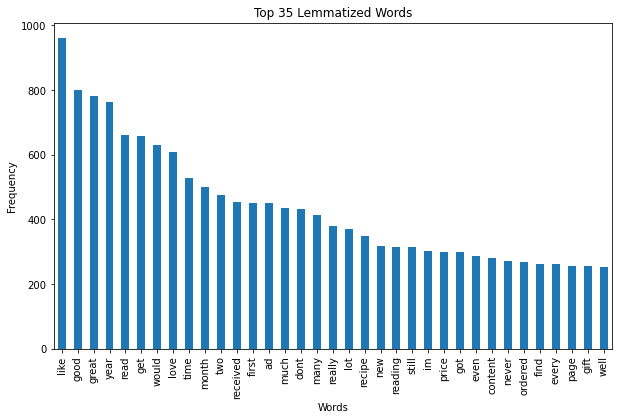

In [47]:
#plotting the lemmatized words

# Count the frequency of lemmatized words and select the top 35
word_counts_lem = pd.Series(lemmatized_words).value_counts().head(35)

# Plot the bar graph
plt.figure(figsize=(10, 6))
word_counts_lem.plot(kind='bar')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 35 Lemmatized Words')

# Display the plot
plt.show()


In [51]:

word_counts_tok = y.value_counts().head(35)
comparison_df = pd.concat([word_counts_lem, word_counts_tok], axis=1)
comparison_df.columns = ['Lemmatized Words Count', 'Tokenized Words Count']

# Display the comparison DataFrame
print(comparison_df)


             Lemmatized Words Count  Tokenized Words Count
like                          960.0                  908.0
good                          801.0                  798.0
great                         782.0                  781.0
year                          764.0                  393.0
read                          660.0                  634.0
get                           657.0                  618.0
would                         630.0                  630.0
love                          609.0                  486.0
time                          528.0                  439.0
month                         499.0                  258.0
two                           477.0                  477.0
received                      454.0                  454.0
first                         451.0                  450.0
ad                            451.0                    NaN
much                          437.0                  437.0
dont                          431.0                  431

In [55]:


# List of documents
documents = word_lem_df['Word'].tolist()

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the documents and transform the documents into a DTM
dtm = vectorizer.fit_transform(documents)

# Get the terms (words) from the vectorizer
terms = vectorizer.get_feature_names()

# Print the DTM
dtm_df = pd.DataFrame(dtm.toarray(), columns=terms)  # Convert DTM to DataFrame



C:\Users\RIA GOVILA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [56]:

# Convert the lemmatized_words list to a pandas Series
lemmatized_words_series = pd.Series(lemmatized_words)

# Filter the Series to include only elements with words containing an underscore
filtered_series = lemmatized_words_series[lemmatized_words_series.str.contains('_')]

# Display the filtered Series
#print(filtered_series)

# Define the set of English words
english_words = set(nltk.corpus.words.words())

# Filter the Series to include only English words
filtered_series = lemmatized_words_series[lemmatized_words_series.isin(english_words)]

# Display the filtered Series
print(filtered_series)

# Replace words containing an underscore with an empty string
lemmatized_words_series = lemmatized_words_series.str.replace(r'\w*[_]\w*', '', regex=True)

# Convert back to a list if needed
lemmatized_words = lemmatized_words_series.tolist()
#print(lemmatized_words)


[nltk_data] Downloading package words to C:\Users\RIA
[nltk_data]     GOVILA\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


2                yet
3                lot
4        advertising
5             weekly
6        publication
            ...     
84092          three
84093          month
84094       purchase
84095           date
84096        receive
Length: 72770, dtype: object


In [58]:
#Topic Modelling

# Create the CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the lemmatized words
X = vectorizer.fit_transform(lemmatized_words)

# Get the feature names
feature_names = vectorizer.get_feature_names()

# Create a DataFrame from the sparse matrix
dtm_df = pd.DataFrame.sparse.from_spmatrix(X, columns=feature_names)

# Convert the DTM to a CSR sparse matrix
dtm_sparse = sp.csr_matrix(dtm_df.values)

# Create the corpus from the DTM
corpus = gensim.matutils.Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create a dictionary mapping of term indices to terms
dictionary = corpora.Dictionary.from_corpus(corpus, id2word=dict(enumerate(dtm_df.columns)))

# Train the LDA model
num_topics = 5
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the top 5 topics
for topic_num, topic_words in lda_model.print_topics(num_topics=5):
    print(f"Topic #{topic_num + 1}:")
    print(topic_words)
    print()


C:\Users\RIA GOVILA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic #1:
0.036*"get" + 0.031*"always" + 0.029*"recipe" + 0.027*"new" + 0.024*"price" + 0.023*"favorite" + 0.023*"reading" + 0.022*"forward" + 0.020*"enjoy" + 0.016*"received"

Topic #2:
0.101*"great" + 0.031*"month" + 0.026*"well" + 0.025*"thing" + 0.021*"many" + 0.021*"dont" + 0.019*"im" + 0.018*"gift" + 0.015*"world" + 0.015*"best"

Topic #3:
0.060*"good" + 0.053*"read" + 0.049*"year" + 0.033*"time" + 0.020*"much" + 0.015*"also" + 0.014*"say" + 0.014*"got" + 0.013*"give" + 0.012*"receive"

Topic #4:
0.050*"like" + 0.025*"every" + 0.023*"lot" + 0.018*"find" + 0.018*"review" + 0.014*"design" + 0.013*"use" + 0.011*"wish" + 0.011*"three" + 0.010*"receiving"

Topic #5:
0.093*"love" + 0.031*"information" + 0.025*"idea" + 0.022*"look" + 0.021*"interesting" + 0.021*"first" + 0.020*"story" + 0.020*"would" + 0.019*"really" + 0.016*"home"

Perplexity Score: -8.390739708698783
Perplexity Score: 4406.075701618922


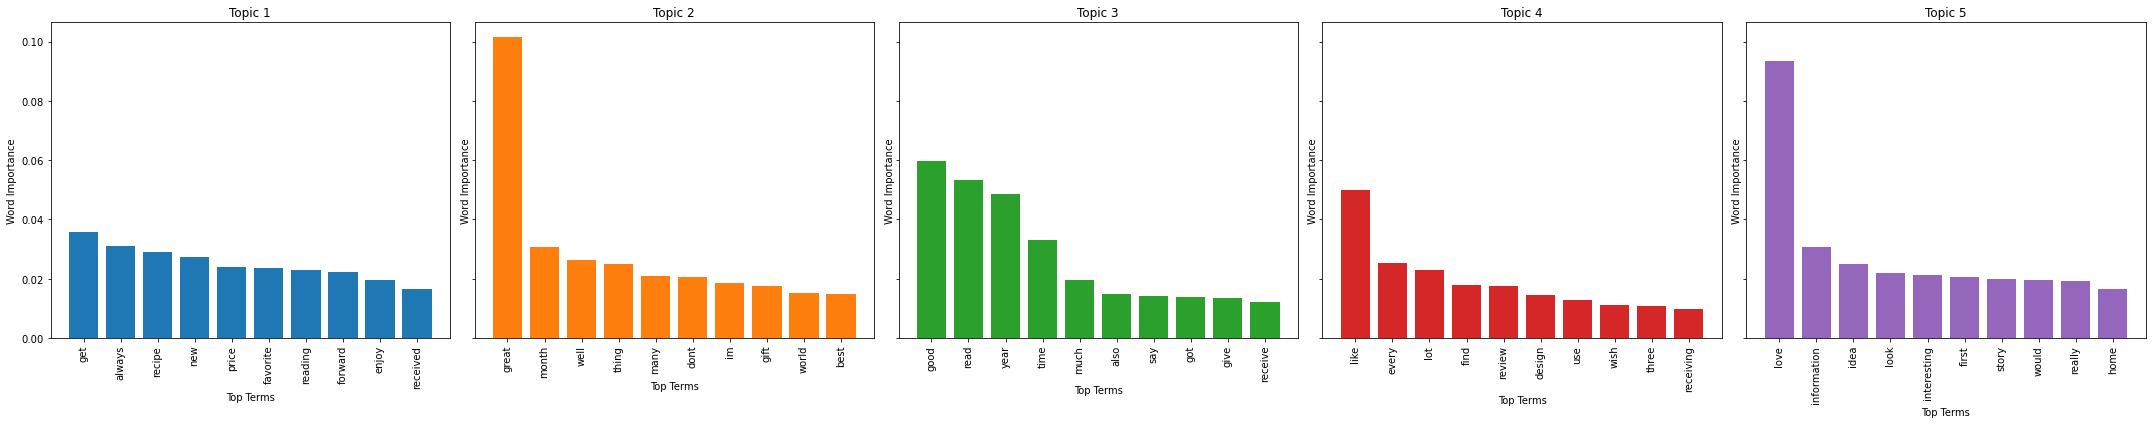

In [61]:
topic_word_distributions = lda_model.get_topics()  # Replace lda_model with your trained LDA model

# Get the top words for each topic
num_top_terms = 10  # Specify the number of top terms to display
top_terms = []

# Calculate top indices outside the loop
top_indices = np.argsort(-topic_word_distributions, axis=1)[:, :num_top_terms]

for topic_idx, topic in enumerate(topic_word_distributions):
    top_words = [feature_names[i] for i in top_indices[topic_idx]]
    top_terms.append(top_words)

# Plot the top terms for each topic
fig, axes = plt.subplots(1, num_topics, figsize=(6*num_topics, 6), sharey=True, tight_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']  # List of colors for bars

for topic_idx, ax in enumerate(axes):
    topic_weights = topic_word_distributions[topic_idx, top_indices[topic_idx]]
    ax.bar(np.arange(num_top_terms), topic_weights, color=colors[topic_idx])
    ax.set_xticks(np.arange(num_top_terms))
    ax.set_xticklabels(top_terms[topic_idx], rotation=90)
    ax.set_xlabel('Top Terms')
    ax.set_ylabel('Word Importance')
    ax.set_title(f'Topic {topic_idx + 1}')

plt.show()


In [63]:
#Sentiment of whole text - not lemmatized version
#work with lematized words not the whole text as the graphs plot same word many times

from textblob import TextBlob

# Create a TextBlob object
blob = TextBlob(text)

# Perform sentiment analysis
sentiment = blob.sentiment

# Get the sentiment polarity
polarity = sentiment.polarity

# Classify the sentiment as positive, negative, or neutral
if polarity > 0:
    sentiment_label = "Positive"
elif polarity < 0:
    sentiment_label = "Negative"
else:
    sentiment_label = "Neutral"

# Print the sentiment analysis result
print("Sentiment: ", sentiment_label)
print("Polarity: ", polarity)
print()

# Tokenize the text into words
words = blob.words


Sentiment:  Positive
Polarity:  0.19007936508511197



In [79]:
#using lemmatized_words and the unique text

from textblob import TextBlob

text1 = ' '.join(lemmatized_words)

# Convert the text to a list of words
words = text1.split()

# Remove repeated words using set
unique_words = set(words)

# Convert the set back to a string
unique_text = ' '.join(unique_words)

# Print the resulting unique text
#print(unique_text)


# Create a TextBlob object
blob = TextBlob(unique_text)

# Perform sentiment analysis
sentiment = blob.sentiment

# Get the sentiment polarity
polarity = sentiment.polarity

# Classify the sentiment as positive, negative, or neutral
if polarity > 0:
    sentiment_label = "Positive"
elif polarity < 0:
    sentiment_label = "Negative"
else:
    sentiment_label = "Neutral"

# Print the sentiment analysis result
print("Sentiment: ", sentiment_label)
print("Polarity: ", polarity)
print()

# Tokenize the text into words
words = blob.words
#print(words)


Sentiment:  Positive
Polarity:  0.040347531388979424

owner extraordinarily catigory including weak save dell unused want instruction hasnt jon resolve rope sheeple wrought immediacy palatable monk twelvei suspect reject fean recipee electron reconsider recipe back bind ashamed robbed illness amongst lofty readily parking complicated corn press reimbursed subscriptionsnow reprint planting eighttwentyten impartial propaganda glyphosate juice ball portada orange regarding batman optimistic periodical northwest evaluate paperwhite trickle gruesome runway altogether continue architecture cheat homeopathy mainstream random kendle treble smith breakthrough different membership tight pricepoint arrive storepharmacygas colorways learns burdened perusal scenario fire put advancement healthy kaepernick poem preteen fascination aaaa strike oneth appetit automagically predictably tipsadvice queasy wrapping manner skinthen eighteenth attacked coworker ninenineyr presented picked genetically digging

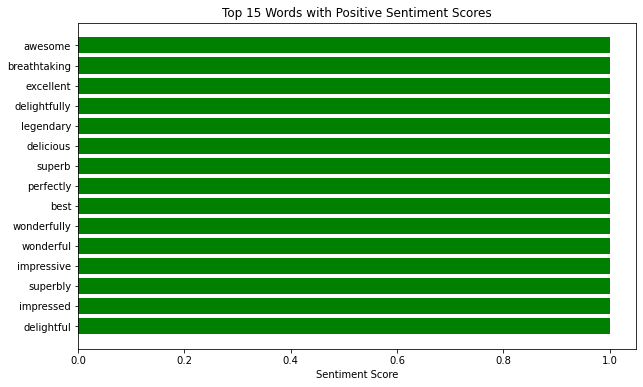

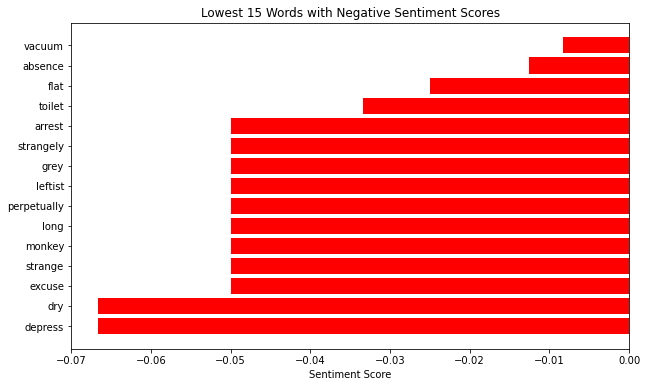

In [81]:
# Create lists to store positive and negative sentiment scores
positive_scores = []
negative_scores = []

# Iterate over the words
for word in unique_words:
    # Create a TextBlob object for the word
    word_blob = TextBlob(word)
    
    # Perform sentiment analysis
    sentiment = word_blob.sentiment
    
    # Get the sentiment polarity
    polarity = sentiment.polarity
    
    # Check if the sentiment is positive or negative
    if polarity > 0:
        positive_scores.append((word, polarity))
    elif polarity < 0:
        negative_scores.append((word, polarity))

# Sort the positive and negative scores in descending order of sentiment scores
positive_scores.sort(key=lambda x: x[1], reverse=True)
negative_scores.sort(key=lambda x: x[1], reverse=True)

# Get the top 15 positive and negative sentiment words and scores
top_positive_words = [word for word, score in positive_scores[:15]]
top_positive_scores = [score for word, score in positive_scores[:15]]

top_negative_words = [word for word, score in negative_scores[:15]]
top_negative_scores = [score for word, score in negative_scores[:15]]


# Plot the top positive sentiment words
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(top_positive_words)), top_positive_scores, color='green')
plt.yticks(np.arange(len(top_positive_words)), top_positive_words)
plt.xlabel('Sentiment Score')
plt.title('Top 15 Words with Positive Sentiment Scores')
plt.gca().invert_yaxis()
plt.show()


# Plot the top negative sentiment words
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(top_negative_words)), top_negative_scores, color='red')
plt.yticks(np.arange(len(top_negative_words)), top_negative_words)
plt.xlabel('Sentiment Score')
plt.title('Lowest 15 Words with Negative Sentiment Scores')
plt.gca().invert_yaxis()
plt.show()




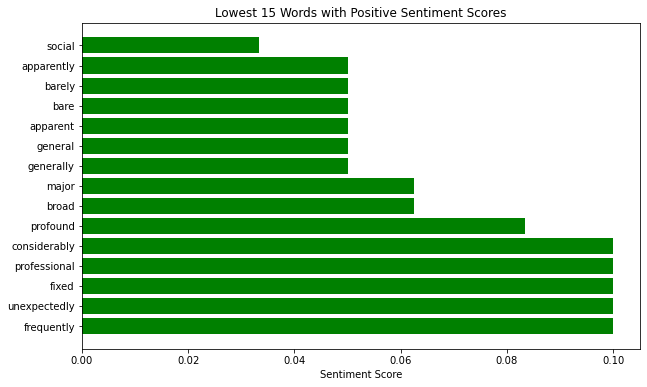

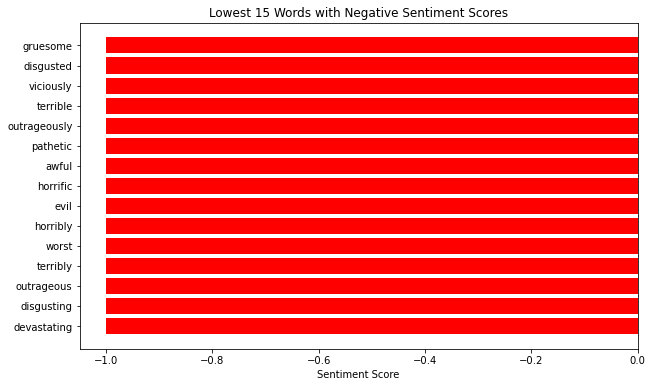

['awesome', 'breathtaking', 'excellent', 'delightfully', 'legendary', 'delicious', 'superb', 'perfectly', 'best', 'wonderfully', 'wonderful', 'impressive', 'superbly', 'impressed', 'delightful']
['gruesome', 'disgusted', 'viciously', 'terrible', 'outrageously', 'pathetic', 'awful', 'horrific', 'evil', 'horribly', 'worst', 'terribly', 'outrageous', 'disgusting', 'devastating']


In [82]:
# Sort the positive and negative scores in ascending order of sentiment scores
positive_scores.sort(key=lambda x: x[1], reverse=False)
negative_scores.sort(key=lambda x: x[1], reverse=False)

# Get the lowest 15 positive and negative sentiment words and scores
bottom_positive_words = [word for word, score in positive_scores[:15]]
bottom_positive_scores = [score for word, score in positive_scores[:15]]
bottom_negative_words = [word for word, score in negative_scores[:15]]
bottom_negative_scores = [score for word, score in negative_scores[:15]]

# Plot the lowest positive sentiment words
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(bottom_positive_words)), bottom_positive_scores, color='green')
plt.yticks(np.arange(len(bottom_positive_words)), bottom_positive_words)
plt.xlabel('Sentiment Score')
plt.title('Lowest 15 Words with Positive Sentiment Scores')
plt.gca().invert_yaxis()
plt.show()

# Plot the top negative sentiment words
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(bottom_negative_words)), bottom_negative_scores, color='red')
plt.yticks(np.arange(len(bottom_negative_words)), bottom_negative_words)
plt.xlabel('Sentiment Score')
plt.title('Lowest 15 Words with Negative Sentiment Scores')
plt.gca().invert_yaxis()
plt.show()

print(top_positive_words)
print(bottom_negative_words)


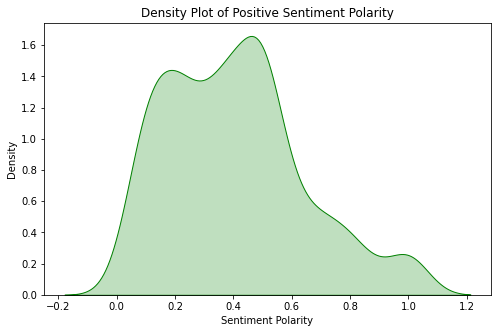

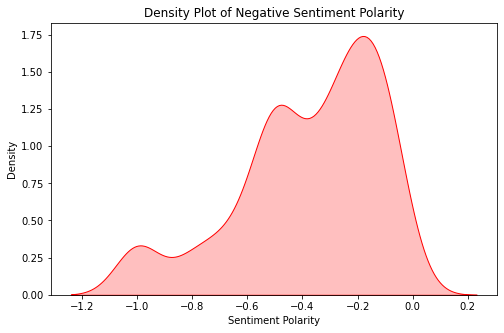

In [84]:

# Create lists to store positive and negative sentiment scores
positive_scores = []
negative_scores = []

# Iterate over the words
for word in unique_words:
    # Create a TextBlob object for the word
    word_blob = TextBlob(word)
    
    # Perform sentiment analysis
    sentiment = word_blob.sentiment
    
    # Get the sentiment polarity
    polarity = sentiment.polarity
    
    # Check if the sentiment is positive or negative
    if polarity > 0:
        positive_scores.append((word, polarity))
    elif polarity < 0:
        negative_scores.append((word, polarity))

# Extract polarities from the positive and negative scores
positive_polarities = [score for _, score in positive_scores]
negative_polarities = [score for _, score in negative_scores]

# Plot the density of positive polarities
plt.figure(figsize=(8, 5))
sns.kdeplot(positive_polarities, shade=True, color='green')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.title('Density Plot of Positive Sentiment Polarity')
plt.show()

# Plot the density of negative polarities
plt.figure(figsize=(8, 5))
sns.kdeplot(negative_polarities, shade=True, color='red')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.title('Density Plot of Negative Sentiment Polarity')
plt.show()


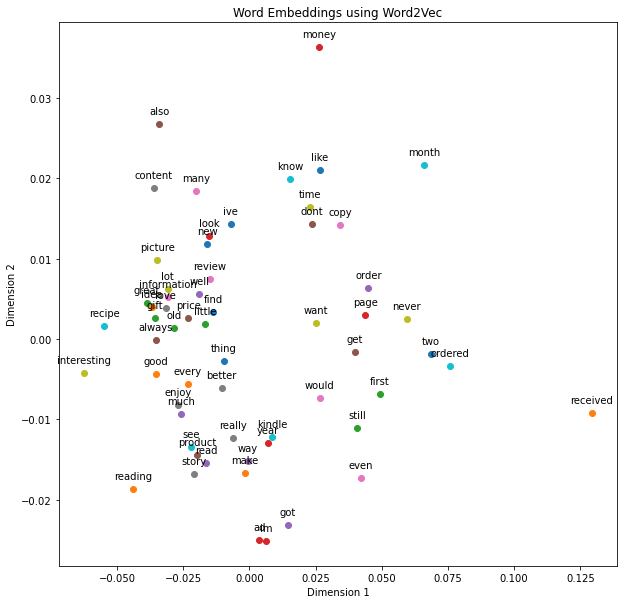

In [85]:

# Train the Word2Vec model
model = Word2Vec(sentences=[lemmatized_words], vector_size=100, window=5, min_count=1, workers=4)

# Get the word embeddings
word_vectors = model.wv

# Select a subset of words for visualization
# Count the frequency of words in lemmatized_words
word_frequency = Counter(lemmatized_words)

# Get the top 20 most common words
top_words = word_frequency.most_common(60)

# Extract the words from the top_words list
words_to_plot = [word for word, _ in top_words]

# Get the corresponding word embeddings
word_embeddings = [word_vectors[word] for word in words_to_plot]

# Apply dimensionality reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_embeddings)

# Plot the word embeddings
fig, ax = plt.subplots(figsize=(10, 10))

for i, word in enumerate(words_to_plot):
    x, y = word_embeddings_2d[i]
    ax.scatter(x, y)
    ax.annotate(word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Set plot title and axis labels
ax.set_title("Word Embeddings using Word2Vec")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Show the plot
plt.show()


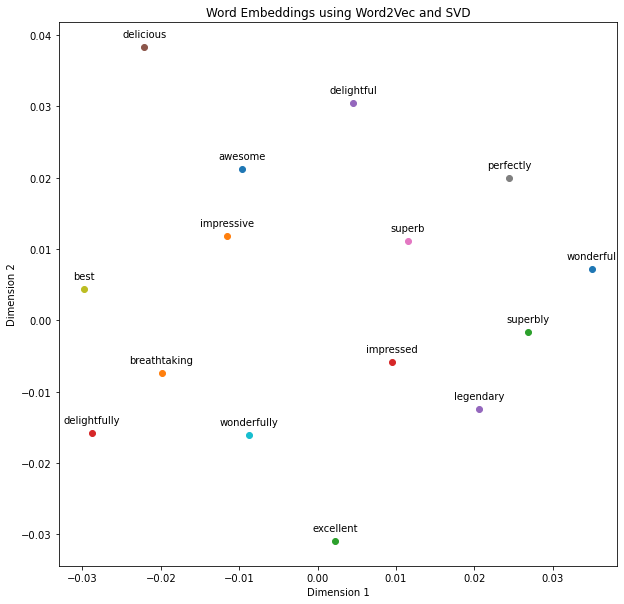

In [86]:
# Train the Word2Vec model
model = Word2Vec(sentences=[lemmatized_words], vector_size=100, window=5, min_count=1, workers=4)

# Get the word embeddings
word_vectors = model.wv

# Select a subset of words for visualization
words_to_plot = ['awesome', 'breathtaking', 'excellent', 'delightfully', 'legendary', 'delicious', 'superb', 
                 'perfectly', 'best', 'wonderfully', 'wonderful', 'impressive', 'superbly', 'impressed', 'delightful']

# Get the corresponding word embeddings
word_embeddings = [word_vectors[word] for word in words_to_plot]

# Perform Singular Value Decomposition (SVD)
svd = TruncatedSVD(n_components=2, random_state=42)
word_embeddings_2d = svd.fit_transform(word_embeddings)

# Plot the word embeddings
fig, ax = plt.subplots(figsize=(10, 10))

for i, word in enumerate(words_to_plot):
    x, y = word_embeddings_2d[i]
    ax.scatter(x, y)
    ax.annotate(word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Set plot title and axis labels
ax.set_title("Word Embeddings using Word2Vec and SVD")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Show the plot
#plt.show()


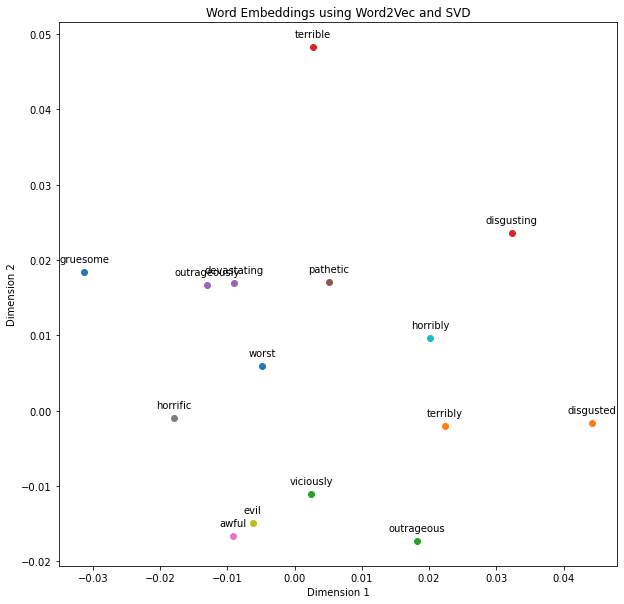

In [87]:

# Train the Word2Vec model
model = Word2Vec(sentences=[lemmatized_words], vector_size=100, window=5, min_count=1, workers=4)

# Get the word embeddings
word_vectors = model.wv

# Select a subset of words for visualization
words_to_plot = ['gruesome', 'disgusted', 'viciously', 'terrible', 'outrageously', 'pathetic', 'awful', 'horrific', 
                  'evil', 'horribly', 'worst', 'terribly', 'outrageous', 'disgusting', 'devastating']
# Get the corresponding word embeddings
word_embeddings = [word_vectors[word] for word in words_to_plot]

# Perform Singular Value Decomposition (SVD)
svd = TruncatedSVD(n_components=2, random_state=42)
word_embeddings_2d = svd.fit_transform(word_embeddings)

# Plot the word embeddings
fig, ax = plt.subplots(figsize=(10, 10))

for i, word in enumerate(words_to_plot):
    x, y = word_embeddings_2d[i]
    ax.scatter(x, y)
    ax.annotate(word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Set plot title and axis labels
ax.set_title("Word Embeddings using Word2Vec and SVD")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Show the plot
plt.show()


[nltk_data] Downloading package stopwords to C:\Users\RIA
[nltk_data]     GOVILA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\RIA
[nltk_data]     GOVILA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                             reviewText  overall  good
0                           havenot recieved issues yet        1     0
1     lot advertising weekly publication lot content...        1     0
2     saw next issue news stand full ads compared on...        1     0
3     got mag kindle never loaded contacted amazon s...        1     0
4                 digital version available iphone ipad        1     0
...                                                 ...      ...   ...
4995  say national geographic abundace information w...        5     1
4996  surprise students created waiting list get han...        5     1
4997                                        love sunset        5     1
4998  always find good recipes articles wish cartoon...        5     1
4999  love magazine thing didnt like took three mont...        5     1

[4999 rows x 3 columns]
0    3000
1    1999
Name: good, dtype: int64


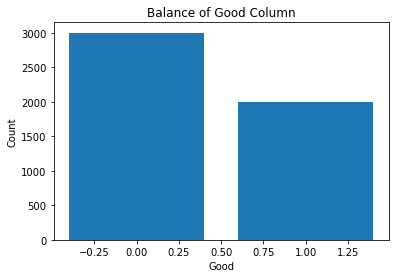

In [88]:

# Download the stopwords corpus if it's not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

# Hitting text table: df1['reviewText']
selected_columns = ['reviewText', 'overall'] 
data = df1[selected_columns]

# Drop rows with NaN values
data = data.dropna()
data.head(5)

# Convert the reviewText column to lowercase
data['reviewText'] = data['reviewText'].str.lower()

# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
data['reviewText'] = data['reviewText'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
data['good'] = (data['overall'] >= 4).astype(int)

print(data)
#data.to_csv('output.csv', index=False)

#data imbalance check
good_counts = data['good'].value_counts()
print(good_counts)

# Plotting the bar chart
plt.bar(good_counts.index, good_counts.values)

# Adding labels and title
plt.xlabel('Good')
plt.ylabel('Count')
plt.title('Balance of Good Column')

# Display the plot
plt.show()

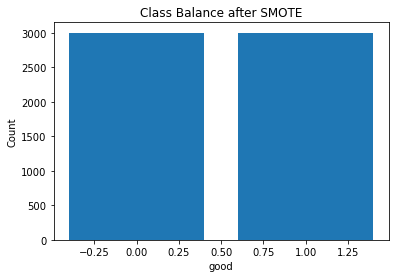

In [90]:

#SMOTE requires numerical data. To use SMOTE, we need to convert the text data into numerical features 
#through text vectorization techniques like TF-IDF or CountVectorizer

# Preprocessing
X = data['reviewText']
y = data['good']

# Text vectorization
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X_vec = vectorizer.fit_transform(X)

# Balancing the classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vec, y)

# Plot the balance of classes
balanced_counts = pd.Series(y_resampled).value_counts()
plt.bar(balanced_counts.index, balanced_counts.values)
plt.xlabel('good')
plt.ylabel('Count')
plt.title('Class Balance after SMOTE')
plt.show()


In [91]:


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model Training
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)

# SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Model Evaluation
nb_accuracy = nb_model.score(X_test.toarray(), y_test)
svm_accuracy = svm_model.score(X_test, y_test)
rf_accuracy = rf_model.score(X_test, y_test)
lr_accuracy = lr_model.score(X_test, y_test)
xgb_accuracy = xgb_model.score(X_test, y_test)

print("Naive Bayes Accuracy:", nb_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
print("XGBoost Accuracy:", xgb_accuracy)

# Make Predictions on New Data
new_reviews = ["This is an excellent product!", "Really bad terrible quality."]
new_reviews_transformed = vectorizer.transform(new_reviews)

nb_predictions = nb_model.predict(new_reviews_transformed.toarray())
svm_predictions = svm_model.predict(new_reviews_transformed)
rf_predictions = rf_model.predict(new_reviews_transformed)
lr_predictions = lr_model.predict(new_reviews_transformed)
xgb_predictions= xgb_model.predict(new_reviews_transformed)

print("Naive Bayes Predictions:")
print(nb_predictions)

print("SVM Predictions:")
print(svm_predictions)

print("Random Forest Predictions:")
print(rf_predictions)

print("Logistic Regression Predictions:")
print(lr_predictions)

print("XG Boost Predictions:")
print(xgb_predictions)


Naive Bayes Accuracy: 0.6741666666666667
SVM Accuracy: 0.8525
Random Forest Accuracy: 0.83
Logistic Regression Accuracy: 0.8158333333333333
XGBoost Accuracy: 0.815
Naive Bayes Predictions:
[1 1]
SVM Predictions:
[1 0]
Random Forest Predictions:
[1 0]
Logistic Regression Predictions:
[1 0]
XG Boost Predictions:
[1 0]


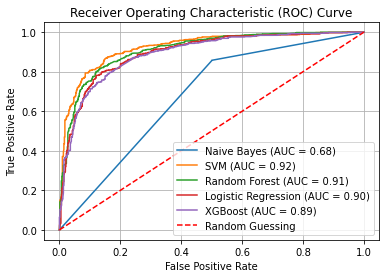

In [92]:
# Compute predicted probabilities for ROC curve
nb_probs = nb_model.predict_proba(X_test.toarray())[:, 1]
svm_probs = svm_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
lr_probs = lr_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds for ROC curve
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# Compute the area under the ROC curve
nb_auc = auc(nb_fpr, nb_tpr)
svm_auc = auc(svm_fpr, svm_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
lr_auc = auc(lr_fpr, lr_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot the ROC curves
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Set legend and grid
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [93]:

# Define a stemmer
stemmer = SnowballStemmer("english")

# Function to preprocess the text
def preprocess_text(text):
    # Split the text into individual words
    words = text.split()
    
    # Filter out unwanted words
    filtered_words = [word for word in words if len(word) > 2
                      and not word.lower().startswith(('magazin', 'issue'))
                      and stemmer.stem(word.lower()) not in ["subscript", "amazon", "articl","mag","one"]]
    
    # Join the filtered words back into a single string
    processed_text = ' '.join(filtered_words)
    
    return processed_text

# Bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['reviewText'].apply(preprocess_text))

# Group reviews by star rating category
categories = data['overall'].unique()
reviews_by_category = {}
for category in categories:
    reviews_by_category[category] = X[data['overall'] == category]

# Calculate word frequencies for each category
for category, reviews in reviews_by_category.items():
    word_frequencies = reviews.sum(axis=0)
    words = vectorizer.get_feature_names()
    word_counts = zip(words, word_frequencies.tolist()[0])
    sorted_words = sorted(word_counts, key=lambda x: x[1], reverse=True)
    top_words = [word for word, _ in sorted_words[:10]]
    
    print("Top 10 words for category", category)
    print(top_words)
    print()


Top 10 words for category 1
['received', 'two', 'would', 'get', 'like', 'first', 'dont', 'ordered', 'never', 'months']

Top 10 words for category 2
['like', 'ads', 'would', 'get', 'read', 'much', 'two', 'dont', 'good', 'many']

Top 10 words for category 3
['like', 'good', 'would', 'much', 'read', 'get', 'many', 'ads', 'great', 'really']

Top 10 words for category 4
['good', 'great', 'like', 'read', 'love', 'would', 'get', 'always', 'reading', 'recipes']

Top 10 words for category 5
['great', 'love', 'read', 'good', 'like', 'always', 'get', 'years', 'price', 'loves']



C:\Users\RIA GOVILA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [95]:


# Calculate word frequencies for each category
for category, reviews in reviews_by_category.items():
    word_frequencies = reviews.sum(axis=0)
    words = vectorizer.get_feature_names()
    word_counts = zip(words, word_frequencies.tolist()[0])
    sorted_words = sorted(word_counts, key=lambda x: x[1], reverse=True)
    top_words = [word for word, _ in sorted_words[:10]]
    
    print("Top 10 words for category", category)
    print(top_words)
    print()
    
    # List three-word ngrams for specific words
    if category == 1 and 'received' in top_words:
        tokens = word_tokenize(' '.join(data['reviewText'].apply(preprocess_text)))
        three_word_ngrams = list(ngrams(tokens, 5))
        three_word_ngrams = [' '.join(ngram) for ngram in three_word_ngrams if 'received' in ngram]
        
        print("Three-word ngrams for 'received' in Category 1:")
        for ngram in three_word_ngrams[:10]:
            print(ngram)
        print()
    
    if category == 2 and 'dont' in top_words:
        tokens = word_tokenize(' '.join(data['reviewText'].apply(preprocess_text)))
        three_word_ngrams = list(ngrams(tokens, 5))
        three_word_ngrams = [' '.join(ngram) for ngram in three_word_ngrams if 'dont' in ngram]
        
        print("Three-word ngrams for 'dont' in Category 2:")
        for ngram in three_word_ngrams[:10]:
            print(ngram)
        print()
    
    if category == 3 and 'great' in top_words:
        tokens = word_tokenize(' '.join(data['reviewText'].apply(preprocess_text)))
        three_word_ngrams = list(ngrams(tokens, 5))
        three_word_ngrams = [' '.join(ngram) for ngram in three_word_ngrams if 'great' in ngram]
        
        print("Three-word ngrams for 'great' in Category 3:")
        for ngram in three_word_ngrams[:10]:
            print(ngram)
        print()
        
    if category == 4 and 'good' in top_words:
        tokens = word_tokenize(' '.join(data['reviewText'].apply(preprocess_text)))
        three_word_ngrams = list(ngrams(tokens, 5))
        three_word_ngrams = [' '.join(ngram) for ngram in three_word_ngrams if 'good' in ngram]
        
        print("Three-word ngrams for 'good' in Category 4:")
        for ngram in three_word_ngrams[:10]:
            print(ngram)
        print()
        
    if category == 5 and 'love' in top_words:
        tokens = word_tokenize(' '.join(data['reviewText'].apply(preprocess_text)))
        three_word_ngrams = list(ngrams(tokens, 5))
        three_word_ngrams = [' '.join(ngram) for ngram in three_word_ngrams if 'enjoy' in ngram]
        
        print("Three-word ngrams for 'enjoy' in Category 5:")
        for ngram in three_word_ngrams[:10]:
            print(ngram)
        print()

Top 10 words for category 1
['received', 'two', 'would', 'get', 'like', 'first', 'dont', 'ordered', 'never', 'months']

Three-word ngrams for 'received' in Category 1:
ordered end november still received
end november still received first
november still received first like
still received first like buy
received first like buy store
ripoff high decided cancel received
high decided cancel received copies
decided cancel received copies publisher
cancel received copies publisher todays
received copies publisher todays date

Top 10 words for category 2
['like', 'ads', 'would', 'get', 'read', 'much', 'two', 'dont', 'good', 'many']

Three-word ngrams for 'dont' in Category 2:
every month objectify women dont
month objectify women dont waste
objectify women dont waste money
women dont waste money unless
dont waste money unless youre
little information help photography dont
information help photography dont bother
help photography dont bother digital
photography dont bother digital exist
dont bo

In [96]:
# Bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['reviewText'].apply(preprocess_text))

# Group reviews by star rating category
ratings = data['overall'].unique()
reviews_by_rating = {}
for rating in ratings:
    reviews_by_rating[rating] = X[data['overall'] == rating]

# Perform topic modeling for each rating
num_topics = 2  # Number of topics to extract
num_top_words = 10  # Number of top words to show for each topic

for rating, reviews in reviews_by_rating.items():
    print("Dominant topics for rating", rating)
    
    # Apply Latent Dirichlet Allocation
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(reviews)
    
    # Get the top words for each topic
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print("Topic {}: {}".format(topic_idx, ', '.join(top_words)))
    
    print()


Dominant topics for rating 1
Topic 0: received, two, would, get, first, like, ordered, dont, never, months
Topic 1: ads, people, used, add, many, like, buy, information, advertisement, advertisements

Dominant topics for rating 2
Topic 0: like, ads, get, would, read, two, dont, much, time, first
Topic 1: recipes, much, advertising, advertisements, good, interesting, money, lot, would, many

Dominant topics for rating 3
Topic 0: like, good, would, get, read, many, ads, much, first, great
Topic 1: interesting, much, like, popular, really, good, lot, photography, great, buy

Dominant topics for rating 4
Topic 0: like, read, love, good, great, first, reading, years, get, time
Topic 1: good, great, like, recipes, ideas, would, interesting, information, get, lot

Dominant topics for rating 5
Topic 0: great, read, love, like, years, get, always, every, year, enjoy
Topic 1: great, love, good, ideas, recipes, price, best, loves, gift, tips



Rating: 1
Word2Vec Vocabulary Size: 795

Rating: 2
Word2Vec Vocabulary Size: 854

Rating: 3
Word2Vec Vocabulary Size: 750

Rating: 4
Word2Vec Vocabulary Size: 653

Rating: 5
Word2Vec Vocabulary Size: 544



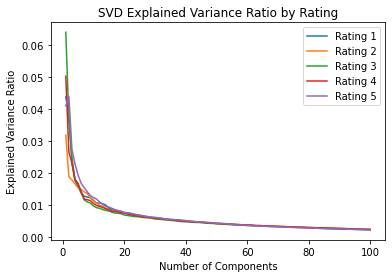

In [97]:
# Group reviews by star rating category
ratings = data['overall'].unique()
reviews_by_rating = {}
explained_variances = []

# Perform SVD and Word2Vec for each rating
for rating in ratings:
    reviews = data[data['overall'] == rating]['reviewText']
    print("Rating:", rating)
    
    # SVD
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(reviews.apply(preprocess_text))
    svd = TruncatedSVD(n_components=100, random_state=42)
    svd.fit(X)
    svd_variance = svd.explained_variance_ratio_
    explained_variances.append(svd_variance)
    
    # Word2Vec
    sentences = [review.split() for review in reviews]
    word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
    word2vec_vocab_size = len(word2vec_model.wv.key_to_index)
    
    print("Word2Vec Vocabulary Size:", word2vec_vocab_size)
    print()

# Plot the explained variance ratio for each rating
for i, rating in enumerate(ratings):
    plt.plot(range(1, len(explained_variances[i]) + 1), explained_variances[i], label=f'Rating {rating}')

# Set plot labels and title
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('SVD Explained Variance Ratio by Rating')
plt.legend()
plt.show()


C:\Users\RIA GOVILA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\RIA GOVILA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\RIA GOVILA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\RIA GOVILA\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names i

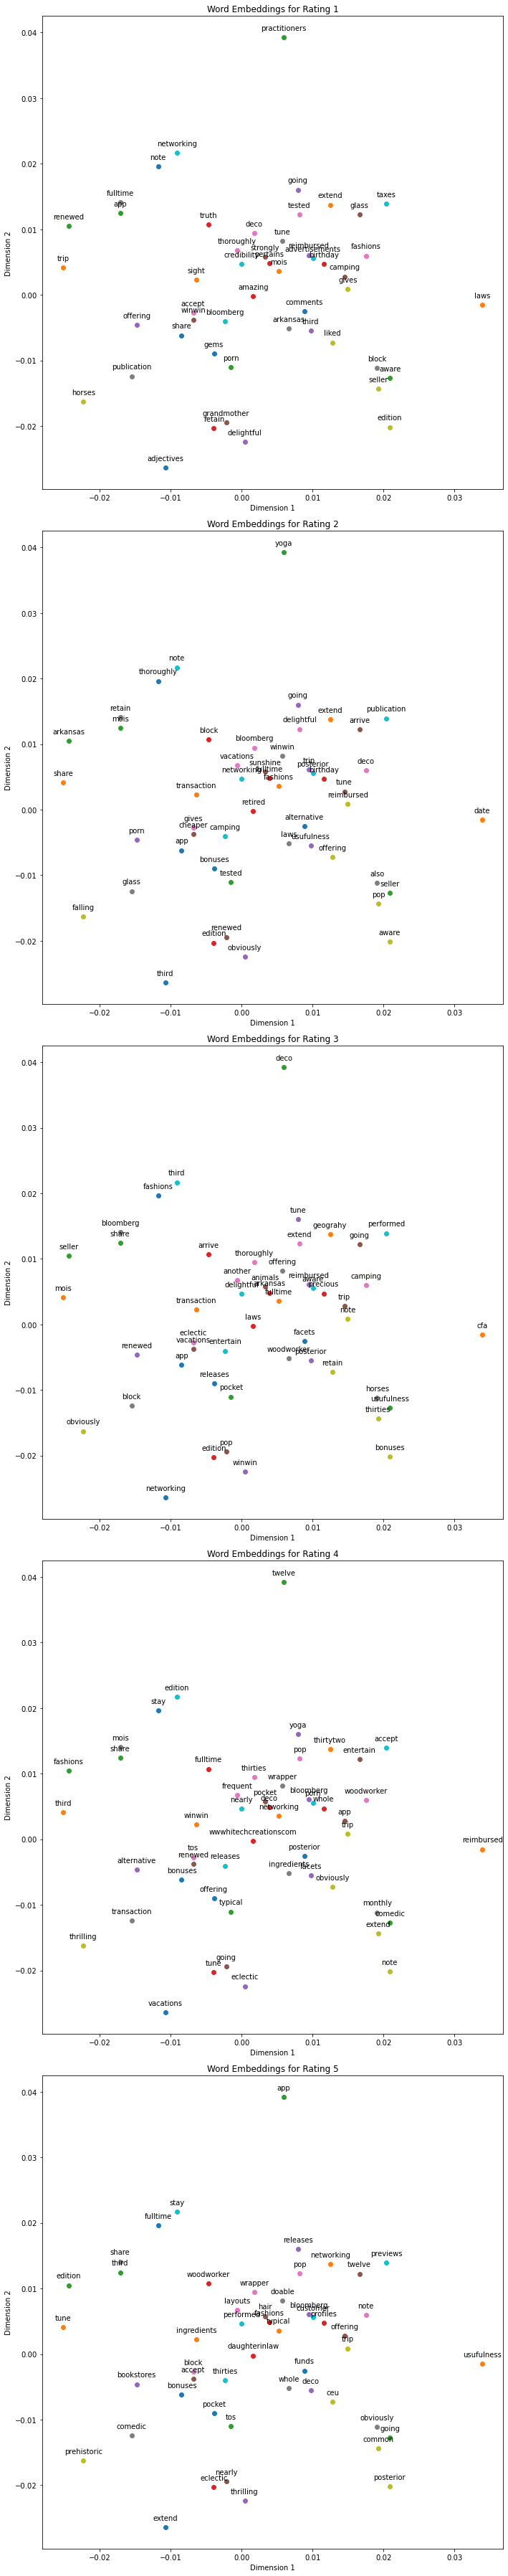

In [99]:


# Create subplots for each rating category
fig, axs = plt.subplots(len(reviews_by_category), 1, figsize=(10, 10 * len(reviews_by_category)))

# Iterate over each rating category
for i, (category, reviews) in enumerate(reviews_by_category.items()):
    # Calculate word frequencies for each category
    word_frequencies = reviews.sum(axis=0)
    words = vectorizer.get_feature_names()
    top_words = [word for word, frequency in zip(words, word_frequencies.tolist()[0]) if frequency > 0]
    top_words = sorted(top_words, key=lambda x: word_frequencies[0, words.index(x)], reverse=True)[:50]

    # Train the Word2Vec model
    model = Word2Vec(sentences=[top_words], vector_size=100, window=5, min_count=1, workers=4)

    # Get the word embeddings
    word_vectors = model.wv

    # Get the corresponding word embeddings
    word_embeddings = [word_vectors[word] for word in top_words]

    # Perform Singular Value Decomposition (SVD)
    svd = TruncatedSVD(n_components=2, random_state=42)
    word_embeddings_2d = svd.fit_transform(word_embeddings)

    # Plot the word embeddings in the corresponding subplot
    ax = axs[i]
    for j, word in enumerate(top_words):
        x, y = word_embeddings_2d[j]
        ax.scatter(x, y)
        ax.annotate(word, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Set subplot title and axis labels
    ax.set_title(f"Word Embeddings for Rating {category}")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


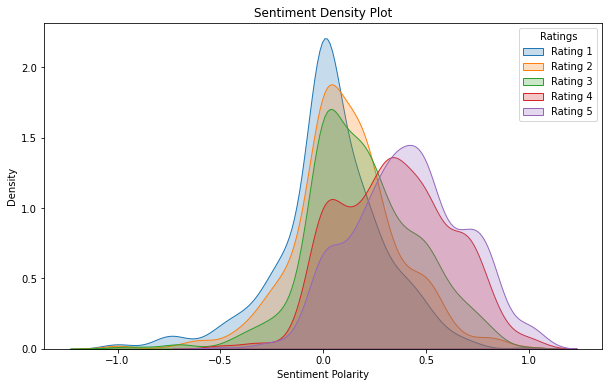

In [39]:
# Define a stemmer
stemmer = SnowballStemmer("english")

# Function to preprocess the text
def preprocess_text(text):
    # Split the text into individual words
    words = text.split()
    
    # Filter out unwanted words
    filtered_words = [word for word in words if len(word) > 2
                      and not word.lower().startswith(('magazin', 'issue'))
                      and stemmer.stem(word.lower()) not in ["subscript", "amazon", "articl","mag","one"]]
    
    # Join the filtered words back into a single string
    processed_text = ' '.join(filtered_words)
    
    return processed_text

# Apply text preprocessing to reviewText column
preprocessed_reviews = data['reviewText'].apply(preprocess_text)

# Create a new DataFrame with preprocessed reviews and overall ratings
preprocessed_data = pd.DataFrame({'reviewText': preprocessed_reviews, 'overall': data['overall']})

# Group reviews by star rating category
reviews_by_category = preprocessed_data.groupby('overall')['reviewText'].apply(list)

# Plot the sentiment density
fig, ax = plt.subplots(figsize=(10, 6))

for category, reviews in reviews_by_category.items():
    # Calculate sentiment polarity for each review
    sentiment_scores = [TextBlob(review).sentiment.polarity for review in reviews]
    
    # Plot the density of sentiment scores with labeled curve
    sns.kdeplot(sentiment_scores, label=f"Rating {category}", shade=True)
    
# Set plot title and axis labels
plt.title("Sentiment Density Plot")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Density")

# Add a legend
plt.legend(title="Ratings")

# Show the plot
plt.show()


In [40]:
# # DistilBERT Code for Reference - To be run on Google Colab
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# df= data

# def perform_sentiment_analysis(df):
#     # Load pre-trained DistilBERT model and tokenizer
#     model_name = 'distilbert-base-uncased'
#     tokenizer = DistilBertTokenizer.from_pretrained(model_name)
#     model = DistilBertForSequenceClassification.from_pretrained(model_name)

#     # Tokenize the text
#     inputs = tokenizer.encode_plus(
#         text,
#         add_special_tokens=True,
#         max_length=512,
#         truncation=True,
#         padding='longest',
#         return_tensors='pt'
#     )

#     # Perform sentiment analysis
#     with torch.no_grad():
#         outputs = model(
#             inputs['input_ids'],
#             attention_mask=inputs['attention_mask']
#         )

#     logits = outputs.logits
#     predicted_labels = torch.argmax(logits, dim=1)
#     probabilities = torch.softmax(logits, dim=1)

#     # Print sentiment prediction and probability
#     sentiment_label = "Positive" if predicted_labels.item() == 1 else "Negative"
#     sentiment_prob = probabilities[0][predicted_labels].item()

#     print("Sentiment:", sentiment_label)
#     print("Confidence:", sentiment_prob)

# perform_sentiment_analysis(df)